# Fitting Saturation-based Simulation Data With Multi-Output
Can having multiple labels per data improve validation loss? 


In [94]:
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from inverse_modelling_tfo.data import (
    generate_data_loaders,
    equidistance_detector_normalization,
    constant_detector_count_normalization,
)
from inverse_modelling_tfo.data.intensity_interpolation import (
    interpolate_exp,
    get_interpolate_fit_params,
    exp_piecewise_affine,
)
from inverse_modelling_tfo.data.interpolation_function_zoo import *
from inverse_modelling_tfo.models import RandomSplit, ValidationMethod, HoldOneOut, CVSplit, CombineMethods
from inverse_modelling_tfo.models.custom_models import (
    SplitChannelCNN,
    PerceptronReLU,
    PerceptronBN,
    PerceptronDO,
    PerceptronBD,
)
from inverse_modelling_tfo.features.build_features import (
    FetalACFeatureBuilder,
    RowCombinationFeatureBuilder,
    TwoColumnOperationFeatureBuilder,
    FetalACbyDCFeatureBuilder,
)
from inverse_modelling_tfo.features.data_transformations import LongToWideIntensityTransformation, ToFittingParameterTransformation
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import torchinfo
from inverse_modelling_tfo.misc.misc_training import set_seed
from pyflowdiagram import draw_process_flow

# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [95]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
# DATA_PATH = r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity_low_conc3.pkl'

DATA_PATH = (
    r"/home/rraiyan/personal_projects/tfo_inverse_modelling/inverse_modelling_tfo/tools/s_based_intensity_low_conc5.pkl"
)

data = pd.read_pickle(DATA_PATH)
# Drop Thickness values which I did not calculate the close concnetration points
equidistance_detector_normalization(data)

# Drop Uterus Thickness for now
data = data.drop(columns="Uterus Thickness")

# Interpolate intensity to remove noise
data = interpolate_exp(data, weights=(1, 0.6), interpolation_function=exp_piecewise_affine, break_indices=[4, 12, 20])
data['Intensity'] = data['Interpolated Intensity']
data = data.drop(columns='Interpolated Intensity')


# Manual log(intensity) normalization
# data['Intensity'] = np.log10(data['Intensity'])        # Far values wayy to small to affect anything. Take log

data_transformer = LongToWideIntensityTransformation()
fitting_param_transformer = ToFittingParameterTransformation()



fitting_params = fitting_param_transformer.transform(data)
data = data_transformer.transform(data)
labels = data_transformer.get_label_names()
intensity_columns = data_transformer.get_feature_names()

# Cleanup
data.dropna(inplace=True)

# Build Features

In [97]:
fetal_conc_group_mapping = {
    10.45 : 0,
    11.00: 0, 
    11.40: 0,
    11.55: 1,
    12.00: 1,
    12.35: 1,
    12.60: 2,
    13.00: 2,
    13.30: 2,
    13.65: 3,
    14.00: 3,
    14.25: 3,
    14.70: 4,
    15.00: 4,
    15.75: 4,
}

In [98]:
data['FconcCenters'] = data['Fetal Hb Concentration'].round(2).map(fetal_conc_group_mapping)
fitting_params['FconcCenters'] = data['FconcCenters']


feature_builder1 = FetalACbyDCFeatureBuilder('FconcCenters', 'perm', intensity_columns, labels, "max")
x_columns1 = feature_builder1.get_feature_names()
# feature_builder2 = TwoColumnOperationFeatureBuilder(x_columns1[len(x_columns1)//2:], x_columns1[:len(x_columns1)//2], "/", False, x_columns1, feature_builder1.get_label_names())
# data1 = feature_builder2(feature_builder1(data))
data1 = feature_builder1(data)

In [99]:
from inverse_modelling_tfo.features.build_features import LogTransformFeatureBuilder


fixed_columns = ['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Saturation", "FconcCenters"]
feature_builder3 = RowCombinationFeatureBuilder(intensity_columns, fixed_columns, ["Fetal Hb Concentration"], 'perm', 2)
# feature_builder4 = LogTransformFeatureBuilder(feature_builder3.get_feature_names(), feature_builder3.get_feature_names(), feature_builder3.get_label_names())
# data2 = feature_builder4(feature_builder3(data))
data2 = feature_builder3(data)

In [100]:
feature_builder5 = FetalACFeatureBuilder('FconcCenters', 'perm', '/', intensity_columns, labels)
x_columns5 = feature_builder5.get_feature_names()
feature_builder6 = TwoColumnOperationFeatureBuilder(x_columns5[len(x_columns5)//2:], x_columns5[:len(x_columns5)//2], "/", False, x_columns5, feature_builder5.get_label_names())
data3 = feature_builder5(data)

In [101]:
feature_builder7 = RowCombinationFeatureBuilder(fitting_param_transformer.get_feature_names(), fixed_columns, ["Fetal Hb Concentration"], 'perm', 2)
data4 = feature_builder7(fitting_params)

In [102]:
# data = pd.concat([data1[labels], data1[feature_builder2.get_fea`ture_names()], data2[feature_builder4.get_feature_names()]], axis=1)
data = pd.concat([data1[feature_builder1.get_label_names()], data1[feature_builder1.get_feature_names()], data2[feature_builder3.get_feature_names()], data3[feature_builder5.get_feature_names()], data4[feature_builder7.get_feature_names()]], axis=1)

In [103]:
# x_columns = feature_builder4.get_feature_names()
x_columns = feature_builder3.get_feature_names() + feature_builder1.get_feature_names() + feature_builder5.get_feature_names() + feature_builder7.get_feature_names()
# x_columns = feature_builder2.get_feature_names()
# x_columns = feature_builder2.get_feature_names() + feature_builder4.get_feature_names() + feature_builder6.get_feature_names()

y_columns = feature_builder1.get_label_names() 


In [104]:
# CleanUp
y_columns.remove('FconcCenters')
# data["ConcDiff"] = data["Fetal Hb Concentration 1"] - data["Fetal Hb Concentration 0"]
# y_columns.append("ConcDiff")
# y_columns.remove("Fetal Hb Concentration 1")
# y_columns.remove("Fetal Hb Concentration 0")

In [105]:
data.columns

Index(['Maternal Wall Thickness', 'Maternal Hb Concentration',
       'Maternal Saturation', 'Fetal Saturation', 'FconcCenters',
       'Fetal Hb Concentration 0', 'Fetal Hb Concentration 1',
       'MAX_ACbyDC_WV1_0', 'MAX_ACbyDC_WV1_1', 'MAX_ACbyDC_WV1_2',
       ...
       'alpha1_1.0_2', 'alpha1_2.0_2', 'alpha2_1.0_2', 'alpha2_2.0_2',
       'alpha3_1.0_2', 'alpha3_2.0_2', 'alpha4_1.0_2', 'alpha4_2.0_2',
       'alpha5_1.0_2', 'alpha5_2.0_2'],
      dtype='object', length=191)

## Normalizing Features
x_columns will be the input features and y_columns are the target

In [106]:
## X -> Predictors
# TODO: Maybe return these columns from the build_feature functions? have a single source of truth
# ratio_columns = list(filter(lambda X: X.isdigit(), data.columns))   # Can be empty 
# intensity_columns = list(filter(lambda X: '_' in X, data.columns))  # Can be empty 
# x_columns = ratio_columns + intensity_columns

## Pass in maternal info
# x_columns += ["Maternal Hb Concentration", "Maternal Saturation"]
# x_columns = list(filter(lambda X: 'alpha' in X, data.columns))

## Scale y
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

## Scale x
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])

# Custom Loss Definition

In [107]:
class WeightedMSE(nn.Module):
    """
    MSE Loss for vector output labels with custom weighting
    """
    def __init__(self, loss_weights: torch.Tensor) -> None:
        super().__init__()
        # Reshape to row vector for broadcasting during loss calculation
        self.loss_weights = loss_weights.reshape(1, -1)
        self.mse_loss = nn.MSELoss(reduction='none')

    
    def forward(self, predicted_tmps, targets):
        loss = self.mse_loss(predicted_tmps, targets)
        loss = loss * self.loss_weights
        return loss.sum() / self.loss_weights.sum()

## Model Configuration

In [108]:
print("In Features :", len(x_columns))  
print("Out Features:", len(y_columns))

In Features : 184
Out Features: 6


In [139]:
IN_FEATURES = len(x_columns)
OUT_FEATURES = len(y_columns)

from inverse_modelling_tfo.models.train_model import ModelTrainerFactory
datagen_kw = {
    'table' : data,
    'data_loader_params' : 
        {
            'batch_size': 256, 'shuffle': True, 'num_workers': 2
        }, 
    'x_columns': x_columns,
    'y_columns': y_columns,
    'validation_method' : HoldOneOut('Maternal Wall Thickness', data['Maternal Wall Thickness'].unique()[3])
    # 'validation_method' : CombineMethods([
        # HoldOneOut('Maternal Wall Thickness', data['Maternal Wall Thickness'].unique()[3]), RandomSplit(0.9)])
    # 'validation_method' : HoldOneOut('Maternal Hb Concentration', 13.0)
    # 'validation_method' : HoldOneOut('Maternal Saturation', 1.0)
}

# criterion = WeightedMSE(torch.Tensor([1.0, 1.0, 1.0,  1.2, 1.0, 1.0]).cuda())
# criterion = WeightedMSE(torch.Tensor([4.0, 1.0, 1.0, 1.0, 1.0, 1.0]).cuda())
criterion = nn.MSELoss()
# criterion = nn.HuberLoss()
# trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 40, 20, 10, OUT_FEATURES], 'dropout_rates': [0.5, 0.5, 0.5]}, generate_data_loaders, datagen_kw, 100, criterion)
# trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 40, 24, 12, 6, OUT_FEATURES], 'dropout_rates': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]}, generate_data_loaders, datagen_kw, 100, criterion)
# trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 25, 12, 8, OUT_FEATURES], 'dropout_rates': [0.5, 0.5, 0.5]}, generate_data_loaders, datagen_kw, 100, criterion)
# trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 10, 10, 5, 5, OUT_FEATURES], 'dropout_rates': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]}, generate_data_loaders, datagen_kw, 100, criterion)
trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 10, 10, 5, OUT_FEATURES], 'dropout_rates': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]}, generate_data_loaders, datagen_kw, 100, criterion)

## Hyper Parameter Tuning

In [140]:
# Custom Train Function 
def train_with_tuning(iteration_config):
    set_seed(42)
    trainer_tuning = trainer_factory.create()
    trainer_tuning.reporting = True     # Report at each epoch to Ray Tune
    if 'batch_size' in iteration_config:
        trainer_tuning.change_batch_size(iteration_config['batch_size'])    # If batch_size needs tuning
    trainer_tuning.set_optimizer(SGD, {'lr': iteration_config["lr"], 'momentum': iteration_config["momentum"]})
    trainer_tuning.run()

In [141]:
# # Hyper Parameter Search 
# iteration_config = {
#     "lr" : tune.loguniform(1e-4, 1e-2),
#     # "lr" : tune.loguniform(1e-7, 1e-4), # Need smaller learning rates when using weighted multi-headed outputs
#     "momentum": tune.uniform(0.9, 0.99),
# }
# scheduler = ASHAScheduler(metric="combined_loss", mode="min", max_t=60, grace_period=5, reduction_factor=2)
# reporter = CLIReporter(metric_columns=["train_loss", "val_loss", "combined_loss", "training_iteration"],
#                        parameter_columns=["lr", "momentum"])
# result = tune.run(train_with_tuning, config=iteration_config, scheduler=scheduler, progress_reporter=reporter,
#                   num_samples=80, resources_per_trial={"cpu": 0, "gpu": 0.2},)

# # Get the trial with the best validation loss 
# best_trial = result.get_best_trial("val_loss", "min", "last")
# print("Best trial config: {}".format(best_trial.config))
# print("Best trial final validation loss: {}".format(best_trial.last_result["val_loss"]))
# print("Best trial final train loss: {}".format(best_trial.last_result["train_loss"]))


<!-- Best trial config: {'lr': 0.0010630834634709364, 'b1': 0.4282116859842134, 'b2': 0.3089991262211405, 'batch_size': 8, 'model': [20, 16, 8, 4, 2, 1]}
Best trial final validation loss: 0.09234625198878348
Best trial final train loss: 0.22368373312056064 -->

In [142]:
# best_trial.config

## Custom Training

In [143]:
set_seed(42)
trainer = trainer_factory.create()
trainer.set_optimizer(SGD, {'lr': 2e-3, 'momentum': 0.948, 'weight_decay': 1e-4})
trainer.change_batch_size(2048)
# trainer.change_batch_size(252)
trainer.epochs = 26
trainer.run()

# trainer.epochs = 30
# trainer.run() 

In [144]:
# trainer.change_batch_size(64)
# trainer.epochs = 20
# trainer.change_batch_size(2048)
# trainer.epochs = 50
# trainer.run()

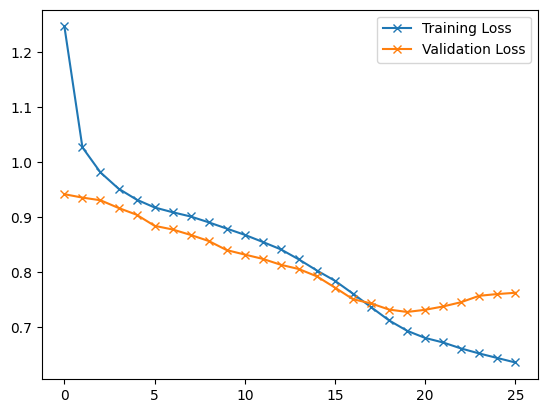

In [145]:
plt.figure()
plt.plot(trainer.train_loss, label='Training Loss', marker='x')
plt.plot(trainer.validation_loss, label='Validation Loss', marker='x')
# plt.yscale('log')
plt.legend()

In [146]:
print(trainer)


        Model Properties:
        PerceptronBD(
  (model): Sequential(
    (0): Linear(in_features=184, out_features=10, bias=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout1d(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout1d(p=0.5, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=5, bias=True)
    (9): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout1d(p=0.5, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=5, out_features=6, bias=True)
    (13): Flatten(start_dim=1, end_dim=-1)
  )
)
        Optimizer Properties"
        SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 0.948
    nesterov: False
    

In [147]:
from inverse_modelling_tfo.visualization import generate_model_error_and_prediction
train_error, train_pred = generate_model_error_and_prediction(trainer.model, trainer.train_loader, y_columns, y_scaler)
val_error, val_pred = generate_model_error_and_prediction(trainer.model, trainer.validation_loader, y_columns, y_scaler)

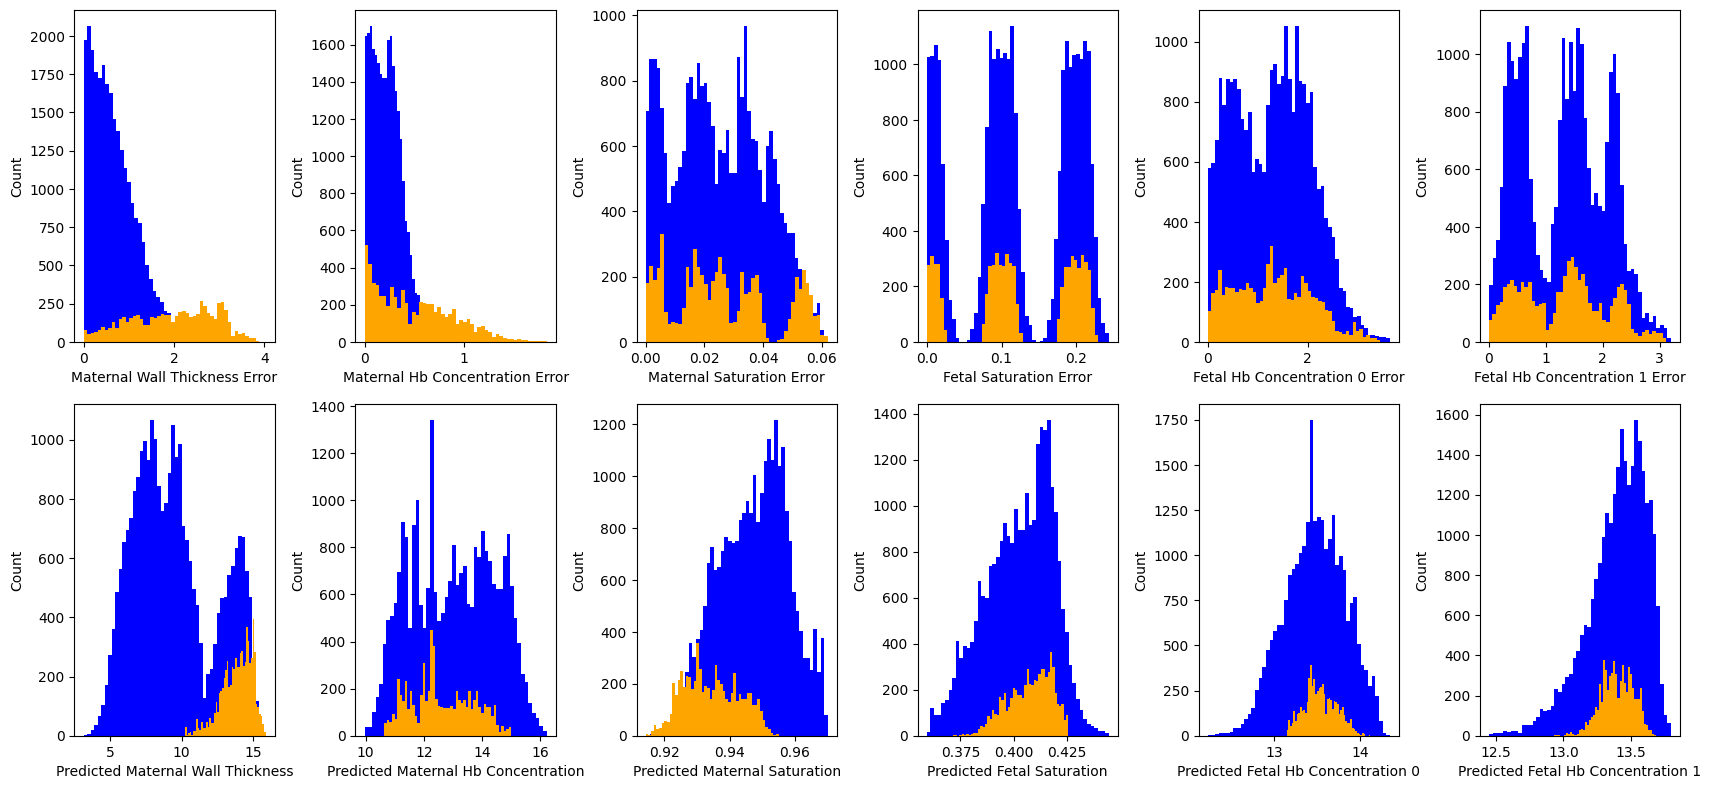

In [148]:
fig, axes = plt.subplots(2, len(y_columns), squeeze=True, figsize=(17, 8))
BIN_COUNT = 50
for i in range(len(y_columns)):
    # Plot Errors
    ax = axes[0, i]
    plt.sca(ax)
    column_name = train_error.columns[i]
    plt.hist(train_error[column_name], bins=BIN_COUNT, color='blue')
    plt.hist(val_error[column_name], bins=BIN_COUNT, color='orange')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    
    # Plot Predictions
    ax = axes[1, i]
    plt.sca(ax)
    column_name = train_pred.columns[i]
    plt.hist(train_pred[column_name], bins=BIN_COUNT, color='blue')
    plt.hist(val_pred[column_name], bins=BIN_COUNT, color='orange')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    
plt.tight_layout()
plt.show()

In [149]:
# # Top Bad Samples
# VIEW_TOP_N = 50
# worst_errors = error_df['Absolute Error'].argsort()[::-1][:VIEW_TOP_N]  # Worst Results
# # worst_errors = error_df['Absolute Error'].argsort()[:VIEW_TOP_N]  # Best Results
# combined_table = data.join(error_df)
# with pd.option_context("display.max_rows", None):
#     display(combined_table[['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation", 'Truth', 'Predicted', 'Absolute Error', '%tage']].iloc[worst_errors, :])

In [150]:
# # Rough MSE's in percentage
# print(f'Train Error(non-normalized): {trainer.train_loss[-1] * y_scaler.var_ }')
# print(f'Validation Error(non-normalized): {trainer.validation_loss[-1] * y_scaler.var_ }')

In [151]:
# Model Info
torchinfo.summary(trainer.model)

Layer (type:depth-idx)                   Param #
PerceptronBD                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       1,850
│    └─BatchNorm1d: 2-2                  20
│    └─Dropout1d: 2-3                    --
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       110
│    └─BatchNorm1d: 2-6                  20
│    └─Dropout1d: 2-7                    --
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       55
│    └─BatchNorm1d: 2-10                 10
│    └─Dropout1d: 2-11                   --
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      36
│    └─Flatten: 2-14                     --
Total params: 2,101
Trainable params: 2,101
Non-trainable params: 0

In [152]:
# model_name = 'msat_percep_irsi'
# import joblib
# # Save Model
# torch.save(model.state_dict(), rf'../models/{model_name}')
# # Save the Scalers for Later Use
# joblib.dump(x_scaler, rf'../models/{model_name}_xscaler')
# joblib.dump(y_scaler, rf'../models/{model_name}_yscaler')

In [153]:
# # Load Model Code
# model = PerceptronReLU([20, 10, 4, 2, 1])
# model.load_state_dict(torch.load(r'../models/fsat_delta_5det_v1'))
# model = model.cuda()
# x_scaler = joblib.load(rf'../models/{model_name}_xscaler')
# y_scaler = joblib.load(rf'../models/{model_name}_yscaler')